## Dependencies

In [1]:
import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers

## TPU configuration

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS: 1


# Model parameters

In [3]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 5
BATCH_SIZE = 2
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Load data

In [4]:
GCS_PATH = KaggleDatasets().get_gcs_path('monet-gan-getting-started')

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)*4
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Monet TFRecord files: 5
Monet image files: 1200
Photo TFRecord files: 20
Photo image files: 7038


## Auxiliar functions

In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string),
        'target':     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def flip(image):
    return tf.image.flip_left_right(image)

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
    return cropped_image

def random_jitter(image):
    # resizing to 286 x 286 x 3 
    image = tf.image.resize(image, [int(256*1.3), int(256*1.3)],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
    # random mirroring
    return image

def load_dataset(filenames,Is_Monet=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    if Is_Monet:
        dataset = dataset.concatenate(dataset.map(flip, num_parallel_calls=AUTOTUNE).shuffle(100000))
        dataset = dataset.concatenate(dataset.map(random_jitter, num_parallel_calls=AUTOTUNE).shuffle(10000, reshuffle_each_iteration=True))
    num_elements = 0
    for element in dataset:
        num_elements += 1
    print(num_elements)
    return dataset

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files,Is_Monet=True)
    photo_ds = load_dataset(photo_files,Is_Monet=False)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1
                

# Model functions
def downsample(filters, size, apply_instancenorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2D(filters, size, strides=strides, padding='same',
                        kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(L.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(L.Dropout(0.5))

    result.add(L.ReLU())

    return result

## Looking at a few Monet paintings

1200


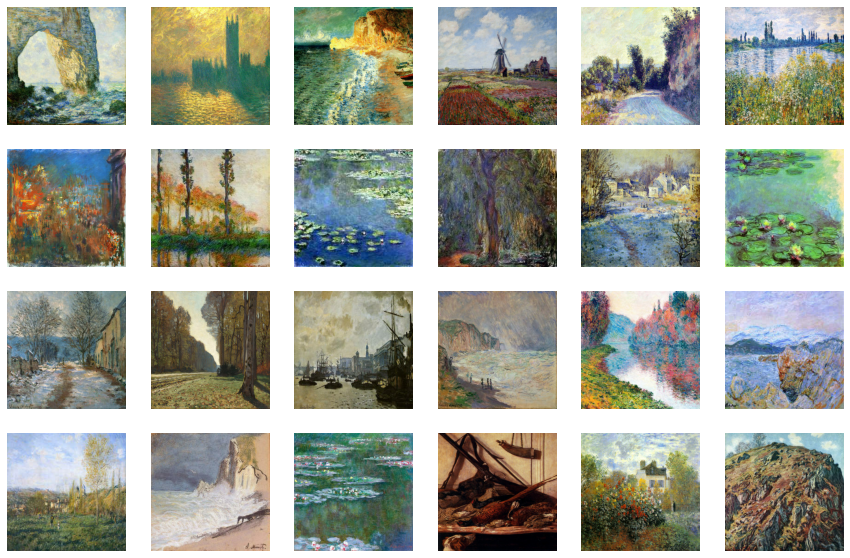

In [6]:
display_samples(load_dataset(MONET_FILENAMES,Is_Monet=True).batch(1), 4, 6)

## Looking at a few photo samples

7038


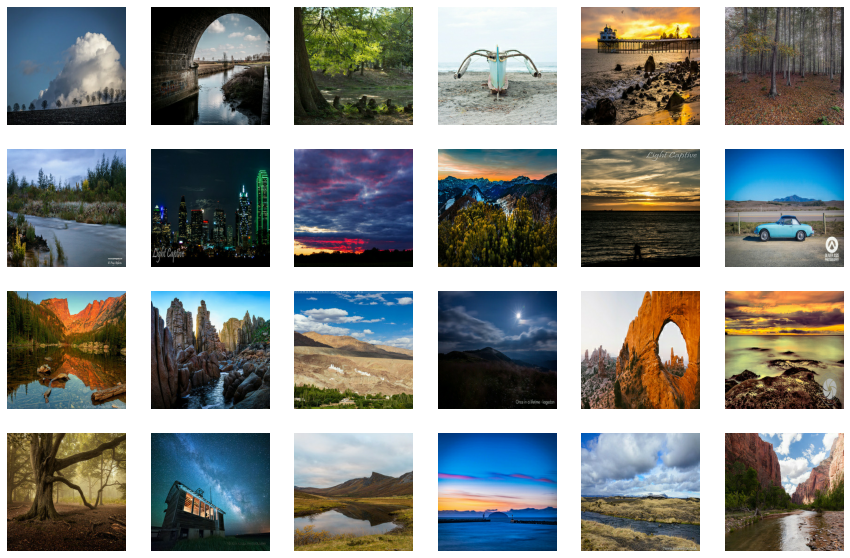

In [7]:
display_samples(load_dataset(PHOTO_FILENAMES,Is_Monet=False).batch(1), 4, 6)

# Generator model

In [8]:
OUTPUT_CHANNELS = 3

def generator_fn():
    inputs = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    initializer = tf.random_normal_initializer(0., 0.02)

    # Define downsampling layers with self-attention mechanism
    def downsample(filters, size, apply_instancenorm=True):
        result = tf.keras.Sequential()
        result.add(L.Conv2D(filters, size, strides=2, padding='same', 
                            kernel_initializer=initializer, use_bias=False))
        if apply_instancenorm:
            result.add(tfa.layers.InstanceNormalization())
        result.add(L.LeakyReLU())
        return result

    # Define upsampling layers with improved upsampling strategy
    def upsample(filters, size, apply_dropout=False):
        result = tf.keras.Sequential()
        result.add(L.Conv2DTranspose(filters, size, strides=2, padding='same', 
                                     kernel_initializer=initializer, use_bias=False))
        result.add(tfa.layers.InstanceNormalization())
        if apply_dropout:
            result.add(L.Dropout(0.5))
        result.add(L.ReLU())
        return result

    # Define a self-attention block
    def self_attention(x):
        channels = x.shape[-1]
    
        # Query, Key, and Value transformations
        f = L.Conv2D(channels // 8, kernel_size=1)(x)  # Query
        g = L.Conv2D(channels // 8, kernel_size=1)(x)  # Key
        h = L.Conv2D(channels, kernel_size=1)(x)       # Value
    
        # Reshape tensors for proper alignment in the Dot layers
        f = L.Reshape((-1, channels // 8))(f)  # (batch_size, height * width, channels // 8)
        g = L.Reshape((-1, channels // 8))(g)  # (batch_size, height * width, channels // 8)
        h = L.Reshape((-1, channels))(h)       # (batch_size, height * width, channels)
    
        # Compute attention map
        attention_map = L.Softmax(axis=-1)(L.Dot(axes=[2, 2])([f, g]))  # (batch_size, height * width, height * width)
    
        # Apply attention map to Value tensor
        attention = L.Dot(axes=[2, 1])([attention_map, h])  # (batch_size, height * width, channels)
    
        # Reshape back to original dimensions
        attention = L.Reshape(x.shape[1:])(attention)  # (batch_size, height, width, channels)
    
        return L.Add()([x, attention])  # Residual connection


    # Downsample stack
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),                           # (bs, 64, 64, 128)
        downsample(256, 4),                           # (bs, 32, 32, 256)
        downsample(512, 4),                           # (bs, 16, 16, 512)
        downsample(512, 4),                           # (bs, 8, 8, 512)
        downsample(512, 4),                           # (bs, 4, 4, 512)
        downsample(512, 4),                           # (bs, 2, 2, 512)
        downsample(512, 4),                           # (bs, 1, 1, 512)
    ]

    # Upsample stack
    up_stack = [
        upsample(512, 4, apply_dropout=True),         # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),         # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),         # (bs, 8, 8, 1024)
        upsample(512, 4),                             # (bs, 16, 16, 1024)
        upsample(256, 4),                             # (bs, 32, 32, 512)
        upsample(128, 4),                             # (bs, 64, 64, 256)
        upsample(64, 4),                              # (bs, 128, 128, 128)
    ]

    # Define the last layer
    last = L.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        # Add self-attention to intermediate layers
        if x.shape[1] in [16, 8]:  # Apply attention at specific spatial resolutions
            x = self_attention(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = L.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

# Discriminator model

In [9]:
def discriminator_fn():
    initializer = tf.random_normal_initializer(0., 0.02)

    def conv_block(x, filters, kernel_size, strides=1, apply_norm=True, apply_dropout=False):
        x = L.Conv2D(filters, kernel_size, strides=strides, padding='same',
                     kernel_initializer=initializer, use_bias=not apply_norm)(x)
        if apply_norm:
            x = tfa.layers.InstanceNormalization()(x)
        x = L.LeakyReLU(alpha=0.2)(x)
        if apply_dropout:
            x = L.Dropout(0.3)(x)
        return x

    inp = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    # Downsample blocks
    x = conv_block(inp, 64, kernel_size=4, strides=2, apply_norm=False)  # (bs, 128, 128, 64)
    x = conv_block(x, 128, kernel_size=4, strides=2)                     # (bs, 64, 64, 128)
    x = conv_block(x, 256, kernel_size=4, strides=2)                     # (bs, 32, 32, 256)
    x = conv_block(x, 512, kernel_size=4, strides=1)                     # (bs, 31, 31, 512)

    # Final convolution to output a single channel
    x = L.ZeroPadding2D()(x)                                             # (bs, 33, 33, 512)
    last = L.Conv2D(1, kernel_size=4, strides=1,
                    kernel_initializer=initializer)(x)                   # (bs, 30, 30, 1)

    return Model(inputs=inp, outputs=last, name='Discriminator')


# Build model (CycleGAN)

In [10]:
with strategy.scope():
    monet_generator = generator_fn() # transforms photos to Monet-esque paintings
    photo_generator = generator_fn() # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_fn() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_fn() # differentiates real photos and generated photos


class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
    
        with tf.GradientTape(persistent=True) as tape:
            # Generator outputs
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
    
            # Identity mapping
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
    
            # Discriminator outputs
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
    
            # Generator losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
                               self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + \
                                   self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + \
                                   self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
    
            # Perceptual loss (optional)
            if hasattr(self, "vgg_model"):
                perceptual_loss_monet = perceptual_loss(self.vgg_model, real_monet, fake_monet)
                perceptual_loss_photo = perceptual_loss(self.vgg_model, real_photo, fake_photo)
                total_monet_gen_loss += perceptual_loss_monet
                total_photo_gen_loss += perceptual_loss_photo
    
            # Discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
    
        # Apply gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
    
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
    
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }


# Loss functions

In [11]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

# Train

In [12]:
with strategy.scope():
    # Create generators
    monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

    # Create discriminators
    monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)
    

history = gan_model.fit(get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, batch_size=BATCH_SIZE), 
                        steps_per_epoch=(n_monet_samples//BATCH_SIZE),
                        epochs=EPOCHS,
                        verbose=2).history

1200
7038
Epoch 1/5
600/600 - 316s - monet_gen_loss: 5.4116 - photo_gen_loss: 3.7905 - monet_disc_loss: 0.7336 - photo_disc_loss: 0.4993
Epoch 2/5
600/600 - 193s - monet_gen_loss: 2.7752 - photo_gen_loss: 3.0231 - monet_disc_loss: 0.4483 - photo_disc_loss: 0.4637
Epoch 3/5
600/600 - 183s - monet_gen_loss: 2.6483 - photo_gen_loss: 2.5856 - monet_disc_loss: 0.6970 - photo_disc_loss: 0.8049
Epoch 4/5
600/600 - 183s - monet_gen_loss: 3.6425 - photo_gen_loss: 3.0129 - monet_disc_loss: 0.9329 - photo_disc_loss: 0.9543
Epoch 5/5
600/600 - 183s - monet_gen_loss: 2.8753 - photo_gen_loss: 3.0953 - monet_disc_loss: 0.4376 - photo_disc_loss: 0.4603


# Visualize predictions

7038


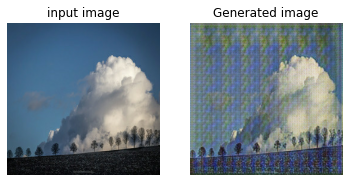

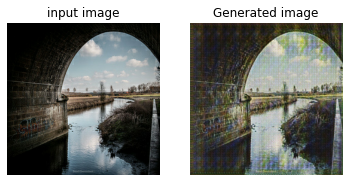

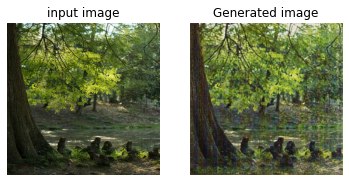

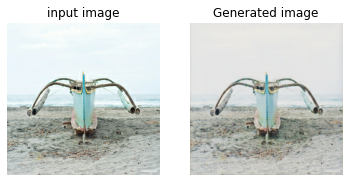

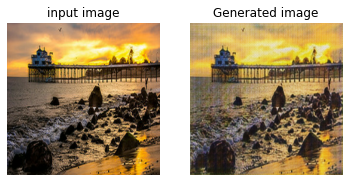

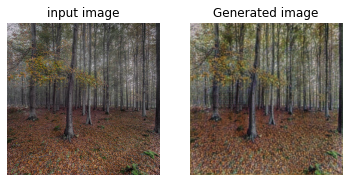

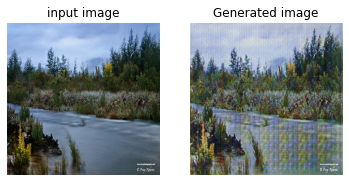

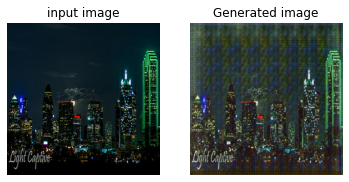

In [13]:
display_generated_samples(load_dataset(PHOTO_FILENAMES,Is_Monet=False).batch(1), monet_generator, 8)

## Make predictions

In [14]:
os.makedirs('../images/') # Create folder to save generated images

predict_and_save(load_dataset(PHOTO_FILENAMES,Is_Monet=False).batch(1), monet_generator, '../images/')

7038


# Submission file

In [15]:
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Generated samples: 7038
